In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model_ft = models.mobilenet_v3_small(pretrained=True)
model_ft.classifier[3] = nn.Linear(model_ft.classifier[3].in_features, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 9.83M/9.83M [03:49<00:00, 44.9kB/s]


In [4]:
model_weights_path = "models/mobilenetv3_small_binary_ucf_crime.pth"

model_ft.load_state_dict(torch.load(model_weights_path, map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

In [5]:
test_loader = dataloaders["test"]

In [6]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    i = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            print(f"Batch {i} done.")
            i = i + 1

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return accuracy, np.array(all_labels), np.array(all_preds)

In [7]:
acc, y_true, y_pred = evaluate_model(model_ft, test_loader)

Batch 0 done.
Batch 1 done.
Batch 2 done.
Batch 3 done.
Batch 4 done.
Batch 5 done.
Batch 6 done.
Batch 7 done.
Batch 8 done.
Batch 9 done.
Batch 10 done.
Batch 11 done.
Batch 12 done.
Batch 13 done.
Batch 14 done.
Batch 15 done.
Batch 16 done.
Batch 17 done.
Batch 18 done.
Batch 19 done.
Batch 20 done.
Batch 21 done.
Batch 22 done.
Batch 23 done.
Batch 24 done.
Batch 25 done.
Batch 26 done.
Batch 27 done.
Batch 28 done.
Batch 29 done.
Batch 30 done.
Batch 31 done.
Batch 32 done.
Batch 33 done.
Batch 34 done.
Batch 35 done.
Batch 36 done.
Batch 37 done.
Batch 38 done.
Batch 39 done.
Batch 40 done.
Batch 41 done.
Batch 42 done.
Batch 43 done.
Batch 44 done.
Batch 45 done.
Batch 46 done.
Batch 47 done.
Batch 48 done.
Batch 49 done.
Batch 50 done.
Batch 51 done.
Batch 52 done.
Batch 53 done.
Batch 54 done.
Batch 55 done.
Batch 56 done.
Batch 57 done.
Batch 58 done.
Batch 59 done.
Batch 60 done.
Batch 61 done.
Batch 62 done.
Batch 63 done.
Batch 64 done.
Batch 65 done.
Batch 66 done.
Batch

In [8]:
acc

0.8140108534780464

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

In [10]:
cm

array([[2300,  677],
       [ 454, 2650]], dtype=int64)

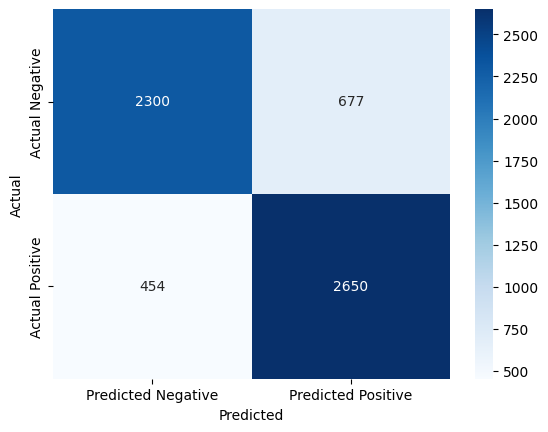

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

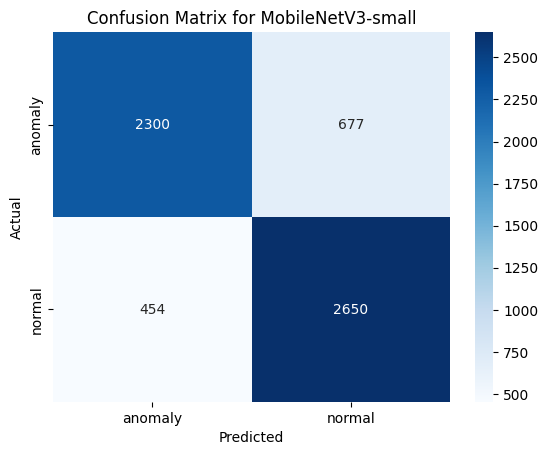

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
class_names = ['anomaly', 'normal']
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MobileNetV3-small')
plt.savefig("EfficientNetB0 Confusion Matrix")
plt.show()


In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [14]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

In [15]:
auc_score = roc_auc_score(y_true, y_pred)
print(f'AUC Score: {auc_score}')

AUC Score: 0.8131634844806748


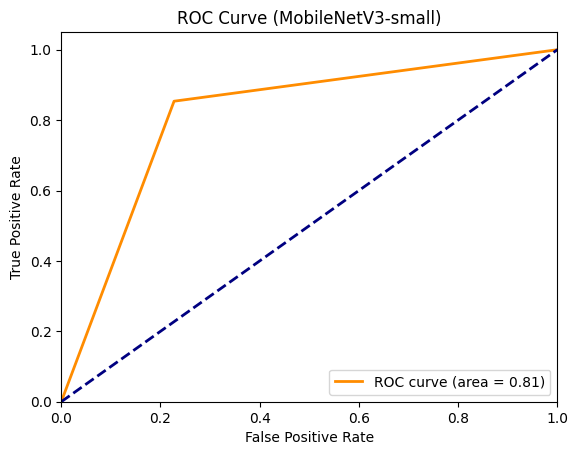

In [16]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for a random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (MobileNetV3-small)')
plt.legend(loc='lower right')
plt.savefig("EfficientNet ROC Curve")
plt.show()

In [17]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

     anomaly       0.84      0.77      0.80      2977
      normal       0.80      0.85      0.82      3104

    accuracy                           0.81      6081
   macro avg       0.82      0.81      0.81      6081
weighted avg       0.82      0.81      0.81      6081

